# **The Impact of Board Members on Financial Performance**

## **Introduction**

**Contributors**
*   **Yi-Cheng Chung**
*   **Yu-Chin (Alyssa)**
*   **Shuo Ming (Chris) Kuo**
*   **Pei Hsin (Bonny) Yang**

## **Load Dataset & Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import statsmodels.api as sm
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# df_finance = pd.read_csv('/content/drive/MyDrive/Dataset/BA875/BA875 Team Project -- Description, Data, & Deliverables/_Dataset 0 (All teams): Company Financials /WRDS_IBES_Company_Financials.csv')
df_finance_original = pd.read_excel('/content/gdrive/MyDrive/BA 875/BA875/WRDS_IBES_Company_Financials_subset.xlsx')
df_ISS = pd.read_csv('/content/gdrive/MyDrive/BA 875/BA875/ISS_Final.csv')
# df_Citation_act = pd.read_csv('/content/drive/MyDrive/Dataset/BA875/BA875 Team Project -- Description, Data, & Deliverables/Dataset 4: Patent Activity (R&D, Innovation)/Patent_Citation_Activity.csv')
# df_ID_link = pd.read_csv('/content/drive/MyDrive/Dataset/BA875/BA875 Team Project -- Description, Data, & Deliverables/Dataset 4: Patent Activity (R&D, Innovation)/Patent_IBES_Company_Financials_ID_Link.csv')


In [ ]:
df_finance = df_finance_original.copy()

### **ISS dataset**

**Firstly, rename certain columns to align with finance dataset standards. Next, address null values and outliers. Additionally, apply one-hot encoding to convert categorical values to numeric. Introduce a new column called 'Seniority' to indicate an employee's tenure. Lastly, create a 'Quarter' column for each year.**

In [ ]:
# Subset ISS dataset
df_ISS_new = df_ISS[['year','director_detail_id','Ticker','Name','Last_name','MeetingDate','FULLNAME','Age','Ethnicity',
                     'DirSince','Year_Term_Ends','Num_Of_Shares','Pcnt_Ctrl_Votingpower','Female','Employment_CEO',
                     'Business_Transaction','Relative_yn','Financial_Expert']]

# Rename
df_ISS_new.rename(columns={'Ticker': 'TICKER'}, inplace=True)
df_ISS_new['Ethnicity'] = df_ISS_new['Ethnicity'].replace(['UNKNOWN', 'N/C'], 'OTHER')

# Handle NaN and outlier
df_ISS_new.dropna(subset=['TICKER','Age','DirSince','Year_Term_Ends','Last_name'], inplace=True)
df_ISS_new = df_ISS_new[(df_ISS_new.DirSince > 0) & (df_ISS_new.Age > 0) & (df_ISS_new.Age < 110)]
df_ISS_new['Ethnicity'] = df_ISS_new['Ethnicity'].replace(['UNKNOWN', 'N/C'], 'OTHER')
df_ISS_new[['Num_Of_Shares', 'Pcnt_Ctrl_Votingpower']] = df_ISS_new[['Num_Of_Shares', 'Pcnt_Ctrl_Votingpower']].fillna(0)

# One-hot encoding
need_one_hot = ['Female', 'Employment_CEO', 'Business_Transaction', 'Financial_Expert','Relative_yn']
for column_name in need_one_hot:
  df_ISS_new[column_name] = df_ISS_new[column_name].replace({'Yes':1}).fillna(0)

# Calculate new column
df_ISS_new['Year_Term_Ends'] = np.where(df_ISS_new['Year_Term_Ends'] > 2023, 2023,df_ISS_new['Year_Term_Ends'])
df_ISS_new['Seniority'] = df_ISS_new['Year_Term_Ends'] - df_ISS_new['DirSince']
df_ISS_new['MeetingDate'] = pd.to_datetime(df_ISS_new['MeetingDate'])
df_ISS_new['year'] = df_ISS_new['MeetingDate'].dt.year
df_ISS_new['month'] = df_ISS_new['MeetingDate'].dt.month

# Create quarter column
conditions = [
    df_ISS_new['month'].isin([1, 2, 3]),
    df_ISS_new['month'].isin([4, 5, 6]),
    df_ISS_new['month'].isin([7, 8, 9]),
    df_ISS_new['month'].isin([10, 11, 12])
]
choices = ['Q1', 'Q2', 'Q3', 'Q4']
df_ISS_new['quarter'] = np.select(conditions, choices)
df_ISS_new['year'] = df_ISS_new['year'].astype('str')
df_ISS_new['quarter'] = df_ISS_new['quarter'].astype('str')
df_ISS_new['year_quarter'] = df_ISS_new['year'] + '_' + df_ISS_new['quarter']

# Drop month
df_ISS_new.drop(['month'],axis=1,inplace=True)

df_ISS_new.head()

,year,director_detail_id,TICKER,Name,Last_name,MeetingDate,FULLNAME,Age,Ethnicity,DirSince,...,Num_Of_Shares,Pcnt_Ctrl_Votingpower,Female,Employment_CEO,Business_Transaction,Relative_yn,Financial_Expert,Seniority,quarter,year_quarter
0,2007,886,A,AGILENT TECHNOLOGIES INC.,LAWRENCE,2007-02-27,DAVID M LAWRENCE,67.0,CAUCASIAN/WHITE,1999.0,...,102713.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,Q1,2007_Q1
1,2007,892,A,AGILENT TECHNOLOGIES INC.,CULLEN,2007-02-27,JAMES G CULLEN,65.0,CAUCASIAN/WHITE,2000.0,...,91922.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,Q1,2007_Q1
2,2007,2603,A,AGILENT TECHNOLOGIES INC.,RAND,2007-02-27,A RAND,63.0,BLACK/AFRICAN AMERICAN,2000.0,...,68504.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,Q1,2007_Q1
3,2007,12170,A,AGILENT TECHNOLOGIES INC.,HWEE,2007-02-27,KOH BOON HWEE,57.0,OTHER,2003.0,...,4900052.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,Q1,2007_Q1
4,2007,12912,A,AGILENT TECHNOLOGIES INC.,HERBOLD,2007-02-27,ROBERT J HERBOLD,65.0,CAUCASIAN/WHITE,2000.0,...,59492.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,Q1,2007_Q1


In [ ]:
df_ISS_new.Ethnicity.unique()

array(['CAUCASIAN/WHITE', 'BLACK/AFRICAN AMERICAN', 'OTHER',
       'ASIAN (EXCLUDE INDIAN/SOUTH ASIAN)', 'INDIAN/SOUTH ASIAN',
       'HISPANIC/LATIN AMERICAN', 'PREFER NOT TO DISCLOSE',
       'NATIVE AMERICAN/ALASKAN NATIVE', 'MIDDLE-EASTERN/NORTH AFRICAN',
       'NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER'], dtype=object)

In [ ]:
# Store dataframe to drive
#df_ISS_new.to_csv('ISS.csv')

### **Finance dataset**

**Begin by filtering the dataset to include only the necessary columns. Remove rows with missing values and fill in any remaining gaps. Create a new column for quarters and filter the years between 2008 and 2023 to align with the ISS dataset. Narrow down the focus to three industries: IT, Energy, and Clothing, and select three companies from each of these industries.**

In [ ]:
# Filter out TICKER in df_finance
ticker_list = df_ISS_new.TICKER.unique()
df_finance = df_finance[df_finance['TICKER'].isin(ticker_list)]

# Drop columns
df_finance.drop(['gvkey','permno','cusip','adate','public_date'],axis=1,inplace=True)

# Create year and month column
df_finance['year'] = df_finance['qdate'].dt.year
df_finance['month'] = df_finance['qdate'].dt.month

# Drop NaN
df_finance.dropna(subset=['roa','invt_act','cash_conversion','inv_turn','at_turn'], inplace=True)

# Fill in NaN
df_finance[['rd_sale','staff_sale']] = df_finance[['rd_sale','staff_sale']].fillna(0)

# Drop Duplicate
df_finance.drop_duplicates(inplace=True)

# Create quarter column
conditions = [
    df_finance['month'].isin([1, 2, 3]),
    df_finance['month'].isin([4, 5, 6]),
    df_finance['month'].isin([7, 8, 9]),
    df_finance['month'].isin([10, 11, 12])
]
choices = ['Q1', 'Q2', 'Q3', 'Q4']
df_finance['quarter'] = np.select(conditions, choices)
df_finance['year'] = df_finance['year'].astype('str')
df_finance['quarter'] = df_finance['quarter'].astype('str')
df_finance['year_quarter'] = df_finance['year'] + '_' + df_finance['quarter']

# Drop month
df_finance.drop('month',axis=1,inplace=True)

# Filter year 2008 to 2023
df_finance = df_finance[(df_finance['year'].astype('int') > 2008) & (df_finance['year'].astype('int') < 2023)].reset_index(drop=True)

# Add category column for our further analysis
df_finance.loc[df_finance['TICKER'].isin(['IBM', 'NVDA', 'ORCL']), 'category'] = 'IT'
df_finance.loc[df_finance['TICKER'].isin(['AEO', 'GPS', 'GES']), 'category'] = 'Clothing'
df_finance.loc[df_finance['TICKER'].isin(['XOM', 'CVX', 'HAL']), 'category'] = 'Energy'

df_finance.head()

,qdate,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale,staff_sale,TICKER,year,quarter,year_quarter,category
0,2009-11-30,0.095,0.572,186.451,2.272,1.001,0.0,0.0,AIR,2009,Q4,2009_Q4,NaN
1,2010-02-28,0.086,0.563,183.882,2.312,0.987,0.0,0.0,AIR,2010,Q1,2010_Q1,NaN
2,2010-05-31,0.093,0.576,192.779,2.188,0.939,0.0,0.0,AIR,2010,Q2,2010_Q2,NaN
3,2010-08-31,0.078,0.575,180.501,2.344,0.972,0.0,0.0,AIR,2010,Q3,2010_Q3,NaN
4,2010-11-30,0.077,0.581,167.138,2.527,1.031,0.0,0.0,AIR,2010,Q4,2010_Q4,NaN


In [ ]:
# Store dataframe to drive
#df_finance.to_csv('/content/gdrive/MyDrive/BA 875/Tableau_data/Finance.csv')

### **Merge dataset**

**First, group the values in df_iss by ticker and year quarter. Calculate the percentage of white people and females. Convert some yes/no values to 0 and 1. Next, merge df_finance and df_groupby, with df_finance as the primary dataframe.**

In [ ]:
# Filter out TICKER in df_ISS
ticker_list = df_finance.TICKER.unique()
df_ISS_new = df_ISS_new[df_ISS_new['TICKER'].isin(ticker_list)].reset_index(drop=True)

In [ ]:
# Create aggregated dataframe, calculate information
df_ISS_new['Race'] = df_ISS_new['Ethnicity']
df_ISS_new['Ethnicity'] = np.where(df_ISS_new['Ethnicity'] == 'CAUCASIAN/WHITE',1,0)

df_groupby = df_ISS_new.groupby(['TICKER','year_quarter']).agg({'Age':'mean','FULLNAME':'count','Ethnicity':'sum',
                                                                'Seniority':'mean','Num_Of_Shares':'sum','Female':'sum',
                                                                'Employment_CEO':'sum','Relative_yn':'sum','Financial_Expert':'sum'}).reset_index()
df_groupby['white_percent'] = df_groupby['Ethnicity'] / df_groupby['FULLNAME']
df_groupby['female_percent'] = df_groupby['Female'] / df_groupby['FULLNAME']
df_groupby['ceo'] = np.where(df_groupby['Employment_CEO']>0,1,0)
df_groupby['relative'] = np.where(df_groupby['Relative_yn']>0,1,0)
df_groupby['expert'] = np.where(df_groupby['Financial_Expert']>0,1,0)
df_groupby['year'] = df_groupby['year_quarter'].str[0:4]

for column_name in ['Age','Seniority','white_percent','female_percent','ceo','relative','expert']:
  df_groupby[column_name] = round(df_groupby[column_name],2)

df_groupby = df_groupby.rename({'FULLNAME':'board_member','Num_Of_Shares':'sum_of_shares'},axis=1)
df_groupby.drop(['Ethnicity','Female','Employment_CEO','Relative_yn','Financial_Expert'],axis=1,inplace=True)
df_groupby.head()

,TICKER,year_quarter,Age,board_member,Seniority,sum_of_shares,white_percent,female_percent,ceo,relative,expert,year
0,A,2007_Q1,62.50,8,7.88,6620123.0,0.75,0.00,1,0,0,2007
1,A,2008_Q1,62.56,9,8.22,6686253.0,0.78,0.11,1,0,1,2008
2,A,2009_Q1,63.44,9,10.22,2017696.0,0.78,0.11,1,0,1,2009
3,A,2010_Q1,64.00,8,10.25,2380774.0,0.75,0.12,1,0,1,2010
4,A,2011_Q1,64.75,8,10.12,1752235.0,0.62,0.12,1,0,1,2011


In [ ]:
# Merge the ISS and Finance data
df_merge = pd.merge(df_finance,df_groupby,on=['TICKER','year'],how='inner')
df_merge.drop(['year_quarter_y'],axis=1,inplace=True) # 'year','quarter',
df_merge.rename({'year_quarter_x':'year_quarter'},axis=1,inplace=True)
df_merge.head()

,qdate,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale,staff_sale,TICKER,year,...,category,Age,board_member,Seniority,sum_of_shares,white_percent,female_percent,ceo,relative,expert
0,2009-11-30,0.095,0.572,186.451,2.272,1.001,0.0,0.0,AIR,2009,...,NaN,62.0,11,9.09,1723384.0,0.64,0.0,1,0,1
1,2010-02-28,0.086,0.563,183.882,2.312,0.987,0.0,0.0,AIR,2010,...,NaN,63.2,10,9.40,1997317.0,0.70,0.0,1,0,1
2,2010-05-31,0.093,0.576,192.779,2.188,0.939,0.0,0.0,AIR,2010,...,NaN,63.2,10,9.40,1997317.0,0.70,0.0,1,0,1
3,2010-08-31,0.078,0.575,180.501,2.344,0.972,0.0,0.0,AIR,2010,...,NaN,63.2,10,9.40,1997317.0,0.70,0.0,1,0,1
4,2010-11-30,0.077,0.581,167.138,2.527,1.031,0.0,0.0,AIR,2010,...,NaN,63.2,10,9.40,1997317.0,0.70,0.0,1,0,1


In [ ]:
# Store dataframe to drive
#df_merge.to_csv('/content/gdrive/MyDrive/BA 875/Tableau_data/Merge.csv')

## **EDA**

In [ ]:
# View ISS column
df_ISS_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154245 entries, 0 to 154244
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   year                   154245 non-null  object        
 1   director_detail_id     154245 non-null  int64         
 2   TICKER                 154245 non-null  object        
 3   Name                   154245 non-null  object        
 4   Last_name              154245 non-null  object        
 5   MeetingDate            154245 non-null  datetime64[ns]
 6   FULLNAME               154245 non-null  object        
 7   Age                    154245 non-null  float64       
 8   Ethnicity              154245 non-null  int64         
 9   DirSince               154245 non-null  float64       
 10  Year_Term_Ends         154245 non-null  float64       
 11  Num_Of_Shares          154245 non-null  float64       
 12  Pcnt_Ctrl_Votingpower  154245 non-null  floa

In [ ]:
# View ISS column values
df_ISS_new.describe()

,director_detail_id,MeetingDate,Age,Ethnicity,DirSince,Year_Term_Ends,Num_Of_Shares,Pcnt_Ctrl_Votingpower,Female,Employment_CEO,Business_Transaction,Relative_yn,Financial_Expert,Seniority
count,154245.000000,154245,154245.000000,154245.000000,154245.000000,154245.000000,1.542450e+05,154245.000000,154245.000000,154245.000000,154245.000000,154245.000000,154245.000000,154245.000000
mean,87117.201530,2015-05-06 14:52:01.003598080,62.493494,0.771720,2006.278557,2016.325878,6.606253e+05,0.732737,0.188823,0.141593,0.015586,0.015657,0.227320,10.047321
min,1.000000,2007-01-02 00:00:00,1.000000,0.000000,1949.000000,2008.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13727.000000,2011-04-28 00:00:00,57.000000,1.000000,2002.000000,2012.000000,7.597000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,43654.000000,2015-05-07 00:00:00,63.000000,1.000000,2007.000000,2016.000000,2.688600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
75%,138218.000000,2019-05-23 00:00:00,68.000000,1.000000,2013.000000,2020.000000,8.770300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
max,484479.000000,2023-12-20 00:00:00,100.000000,1.000000,2023.000000,2023.000000,1.290648e+09,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,74.000000
std,96535.004873,NaN,8.184887,0.419725,9.343514,4.526255,7.749589e+06,4.794605,0.391369,0.348633,0.123866,0.124145,0.419102,7.897830


In [ ]:
# View finance columns
df_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56239 entries, 0 to 56238
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   qdate            56239 non-null  datetime64[ns]
 1   roa              56239 non-null  float64       
 2   invt_act         56239 non-null  float64       
 3   cash_conversion  56239 non-null  float64       
 4   inv_turn         56239 non-null  float64       
 5   at_turn          56239 non-null  float64       
 6   rd_sale          56239 non-null  float64       
 7   staff_sale       56239 non-null  float64       
 8   TICKER           56239 non-null  object        
 9   year             56239 non-null  object        
 10  quarter          56239 non-null  object        
 11  year_quarter     56239 non-null  object        
 12  category         472 non-null    object        
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 5.6+ MB


In [ ]:
# View Finance column values
df_finance.describe()

,qdate,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale,staff_sale
count,56239,56239.000000,56239.000000,56239.000000,56239.000000,56239.000000,56239.000000,56239.000000
mean,2015-11-29 19:00:06.849339136,0.133790,0.283667,91.610993,24.577494,1.063354,0.063813,0.016667
min,2009-09-30 00:00:00,-3.086000,0.000000,0.005000,0.042000,0.002000,0.000000,0.000000
25%,2012-06-30 00:00:00,0.086000,0.134000,38.793000,3.210000,0.584000,0.000000,0.000000
50%,2015-09-30 00:00:00,0.128000,0.262000,73.264000,5.197000,0.878000,0.005000,0.000000
75%,2019-03-31 00:00:00,0.180000,0.395000,117.875500,10.276000,1.345000,0.050000,0.000000
max,2022-10-31 00:00:00,1.989000,5.389000,8106.750000,35002.100000,11.055000,198.740000,3.484000
std,NaN,0.111311,0.192196,108.802847,386.433037,0.745386,1.243775,0.081753


In [ ]:
df_finance.groupby(['category','quarter']).agg({'roa':'mean','invt_act':'mean',
                                                                'cash_conversion':'mean','inv_turn':'mean','at_turn':'mean',
                                                                'rd_sale':'mean'})

roa  invt_act  cash_conversion   inv_turn   at_turn  \
category quarter                                                             
Clothing Q1       0.189282  0.367590        48.700744   5.096897  1.651333   
         Q2       0.186538  0.404103        54.727077   4.480128  1.609000   
         Q3       0.182615  0.408872        55.269564   4.459667  1.602923   
         Q4       0.183571  0.407500        55.380357   4.469071  1.598167   
Energy   Q1       0.149359  0.236641        37.256692  13.763615  0.843128   
         Q2       0.151205  0.236769        36.721179  13.791667  0.844692   
         Q3       0.155214  0.234881        36.682190  13.764452  0.858810   
         Q4       0.145432  0.238486        40.677405  13.943730  0.844514   
IT       Q1       0.182316  0.050237        56.676105  17.016342  0.635158   
         Q2       0.186385  0.049641        61.244154  16.358538  0.624897   
         Q3       0.186850  0.050075        56.577050  16.616450  0.627725   
         Q4       0.182590  0.053103        59.876564  16.999846  0.635769   

                   rd_sale  
category quarter            
Clothing Q1       0.000436  
         Q2       0.000462  
         Q3       0.000462  
         Q4       0.000429  
Energy   Q1       0.008872  
         Q2       0.008667  
         Q3       0.008833  
         Q4       0.009081  
IT       Q1       0.154684  
         Q2       0.153026  
         Q3       0.151950  
         Q4       0.157769

In [ ]:
df_issnewnew = df_ISS_new.copy()
df_issnewnew.loc[df_issnewnew['TICKER'].isin(['IBM', 'NVDA', 'ORCL']), 'category'] = 'IT'
df_issnewnew.loc[df_issnewnew['TICKER'].isin(['AEO', 'GPS', 'GES']), 'category'] = 'Clothing'
df_issnewnew.loc[df_issnewnew['TICKER'].isin(['XOM', 'CVX', 'HAL']), 'category'] = 'Energy'

In [ ]:
ceo_data = df_issnewnew[df_issnewnew['Employment_CEO'] == 1]

ceo_age = ceo_data.groupby('category').agg({
    'Age': 'mean',
    'Seniority': 'mean'
}).reset_index()

ceo_age


,category,Age,Seniority
0,Clothing,59.796296,13.055556
1,Energy,59.298851,6.678161
2,IT,58.141304,12.978261


<Axes: xlabel='Age', ylabel='Seniority'>

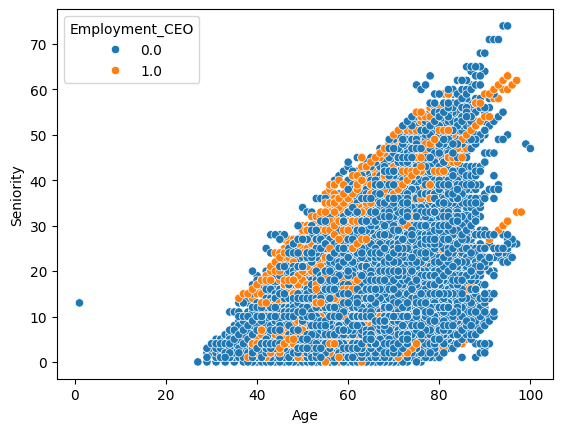

In [ ]:
sns.scatterplot(x='Age',y='Seniority',data=df_ISS_new,hue='Employment_CEO')

<Axes: xlabel='Num_Of_Shares'>

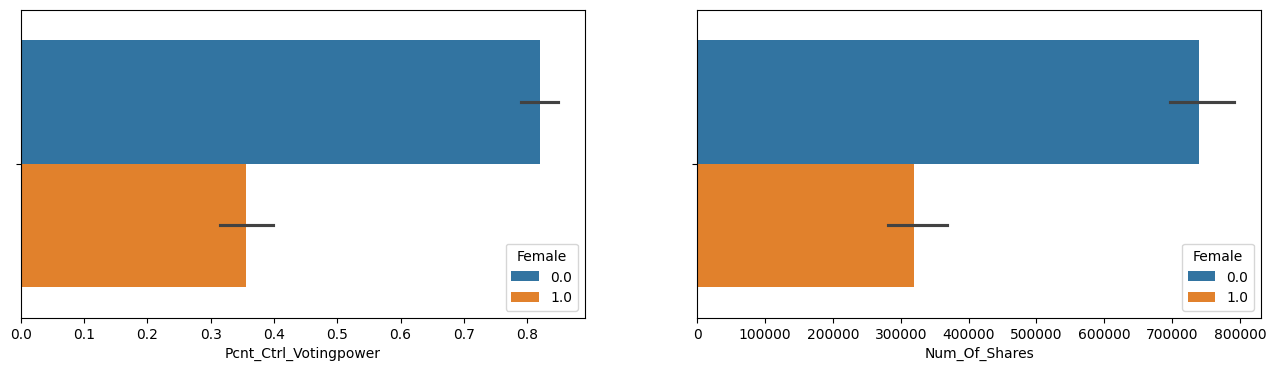

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.barplot(x='Pcnt_Ctrl_Votingpower', data=df_ISS_new, hue='Female', ax=axes[0])
sns.barplot(x='Num_Of_Shares', data=df_ISS_new, hue='Female', ax=axes[1])

In [ ]:
df_eda = df_merge.copy()

**- Roa : The energy sector's capital-intensive nature, necessitating substantial investments in infrastructure, often results in larger asset bases, diluting Return on Assets (ROA) despite generating significant revenue.**

**- Invt act : The clothing industry's consistently higher inventory levels relative to current assets suggest a need to maintain substantial stock to meet consumer preferences and seasonal demands.**

**- inv_turn : The IT industry's exceptionally high inventory turnover rate reflects efficient inventory management driven by rapid technological obsolescence and high demand for current technology products.**

**- at_turn : The clothing industry's high asset turnover ratio indicates effective utilization of assets to generate sales, typical of retail businesses reliant on high-turnover, low-value assets.**

**- Rd_sale : The IT industry's significant investment in research and development, evidenced by a high R&D to sales ratio, underscores its commitment to constant innovation and technological advancement to remain competitive.**

In [ ]:
df_eda.groupby(['category']).agg({'roa':'mean','invt_act':'mean',
                                                                'cash_conversion':'mean','inv_turn':'mean','at_turn':'mean',
                                                                'rd_sale':'mean'})

,roa,invt_act,cash_conversion,inv_turn,at_turn,rd_sale
category,,,,,,
Clothing,0.185465,0.397214,53.554547,4.623472,1.615031,0.000447
Energy,0.152503,0.233399,38.525758,13.901510,0.854418,0.008961
IT,0.184564,0.050763,58.592833,16.745231,0.630840,0.154340


**Generally, the average age of board members across these sectors is in the 60s, indicating a prevalence of experienced leaders in governance roles. In the Energy sector, board members exhibit notably lower seniority averages of about 7.3 years compared to their counterparts in other industries, suggesting a relatively newer composition of board members. Despite this, each industry includes financial experts in its board meetings, underlining the emphasis on financial oversight and expertise in corporate governance. Another key insight is the predominance of white board members across all sectors. Furthermore, familial or relational ties within the board structures are relatively low, with IT showing a minor presence of such relationships at 14.74%.**

In [ ]:
df_eda.groupby('category').agg({'Age':'mean','board_member':'mean','Seniority':'mean','relative':'mean','expert':'mean','white_percent':'mean', 'female_percent':'mean'})

,Age,board_member,Seniority,relative,expert,white_percent,female_percent
category,,,,,,,
Clothing,62.505220,8.805031,12.203962,0.339623,1.000000,0.758616,0.238742
Energy,63.707386,11.241830,7.311765,0.000000,1.000000,0.779869,0.215359
IT,64.441603,12.108974,12.345449,0.147436,0.974359,0.795769,0.189936


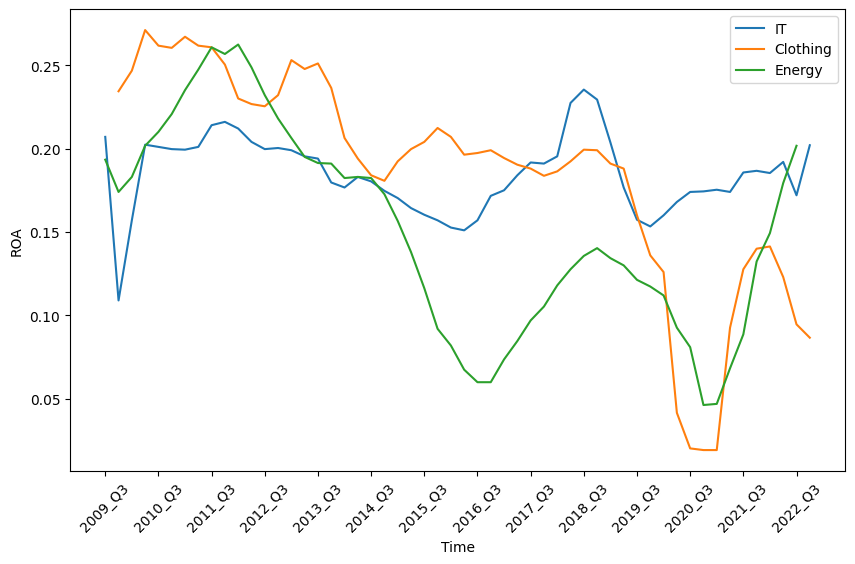

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for each industry category
industry_it = df_eda[df_eda['category'] == 'IT']
industry_clothing = df_eda[df_eda['category'] == 'Clothing']
industry_energy = df_eda[df_eda['category'] == 'Energy']

# Group and aggregate each industry category
industry_it_roa = industry_it.groupby(['year_quarter'])['roa'].mean().reset_index()
industry_clothing_roa = industry_clothing.groupby(['year_quarter'])['roa'].mean().reset_index()
industry_energy_roa = industry_energy.groupby(['year_quarter'])['roa'].mean().reset_index()


# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='year_quarter', y='roa', data=industry_it_roa, label='IT')
sns.lineplot(x='year_quarter', y='roa', data=industry_clothing_roa, label='Clothing')
sns.lineplot(x='year_quarter', y='roa', data=industry_energy_roa, label='Energy')

xticks_labels = industry_it_roa['year_quarter'].iloc[::4]
plt.xticks(ticks=xticks_labels, labels=xticks_labels, rotation=45)
plt.xlabel('Time')
plt.ylabel('ROA')

plt.legend()

plt.show()



## **Regression**

In [ ]:
# !pip install stargazer
# from stargazer.stargazer import Stargazer

In [ ]:
import statsmodels.formula.api as smf
# Prepare for regression
df_regression = df_merge.copy()
df_regression.columns

Index(['qdate', 'roa', 'invt_act', 'cash_conversion', 'inv_turn', 'at_turn',
       'rd_sale', 'staff_sale', 'TICKER', 'year', 'quarter', 'year_quarter',
       'Age', 'board_member', 'Seniority', 'sum_of_shares', 'white_percent',
       'female_percent', 'ceo', 'relative', 'expert'],
      dtype='object')

In [ ]:
df_merge.relative.value_counts()

relative
0    41321
1     4309
Name: count, dtype: int64

### **Regression on overall**

**At this stage, we aim to conduct regression analysis across all companies in the overall dataset. We'll explore three potential dependent variables: "Return on Assets" (ROA), "Inventory Turnover," and "Asset Turnover." In the subsequent section, we'll focus on running regression analysis for three prominent companies within the three industries previously selected.**

In [ ]:
# Regression on roa
reg_overall = smf.ols('roa ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_regression).fit()
print(reg_overall.summary())

                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     52.77
Date:                Thu, 02 May 2024   Prob (F-statistic):          1.11e-228
Time:                        00:31:40   Log-Likelihood:                 43482.
No. Observations:               45630   AIC:                        -8.692e+04
Df Residuals:                   45607   BIC:                        -8.672e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1910      0.010     

In [ ]:
# Regression on inventory turnover
reg_overall = smf.ols('inv_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_regression).fit()
print(reg_overall.summary())

                            OLS Regression Results                            
Dep. Variable:               inv_turn   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.710
Date:                Thu, 02 May 2024   Prob (F-statistic):           9.99e-25
Time:                        00:31:32   Log-Likelihood:            -3.4069e+05
No. Observations:               45630   AIC:                         6.814e+05
Df Residuals:                   45607   BIC:                         6.816e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -299.5856     45.787     

In [ ]:
# Regression on total asset returnover
reg_overall = smf.ols('at_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_regression).fit()
print(reg_overall.summary())

                            OLS Regression Results                            
Dep. Variable:                at_turn   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     77.33
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        00:31:22   Log-Likelihood:                -49891.
No. Observations:               45630   AIC:                         9.983e+04
Df Residuals:                   45607   BIC:                         1.000e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3169      0.078     

### **Regression on Technology companies**

In [ ]:
# Get company subsets
df_tech = df_regression[df_regression['TICKER'].isin(['NVDA','IBM','ORCL'])]

# Regression on roa
roa_tech = smf.ols('roa ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_tech).fit()
print(roa_tech.summary())

                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     6.741
Date:                Thu, 02 May 2024   Prob (F-statistic):           8.62e-13
Time:                        00:49:34   Log-Likelihood:                 260.71
No. Observations:                 156   AIC:                            -477.4
Df Residuals:                     134   BIC:                            -410.3
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3906      0.096     

In [ ]:
# Regression on inventory turnover
inv_tech = smf.ols('inv_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_tech).fit()
print(inv_tech.summary())

                            OLS Regression Results                            
Dep. Variable:               inv_turn   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     18.80
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.99e-30
Time:                        00:49:35   Log-Likelihood:                -487.95
No. Observations:                 156   AIC:                             1020.
Df Residuals:                     134   BIC:                             1087.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -87.4676     11.604     

In [ ]:
# Regression on total asset turnover
at_tech = smf.ols('at_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_tech).fit()
print(at_tech.summary())

                            OLS Regression Results                            
Dep. Variable:                at_turn   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     27.11
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.19e-38
Time:                        00:49:35   Log-Likelihood:                 150.92
No. Observations:                 156   AIC:                            -257.8
Df Residuals:                     134   BIC:                            -190.7
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7706      0.193     

### **Regression on Energy companies**

In [ ]:
# Get company subsets
df_energy = df_regression[df_regression['TICKER'].isin(['XOM','CVX','HAL'])]

# Regression on roa
roa_energy = smf.ols('roa ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + expert',data=df_energy).fit()
print(roa_energy.summary())

                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     37.92
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.34e-44
Time:                        00:49:35   Log-Likelihood:                 339.74
No. Observations:                 153   AIC:                            -639.5
Df Residuals:                     133   BIC:                            -578.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1677      0.054     

In [ ]:
# Regression on inventory turnover
inv_energy = smf.ols('inv_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + expert',data=df_energy).fit()
print(inv_energy.summary())

                            OLS Regression Results                            
Dep. Variable:               inv_turn   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     12.20
Date:                Thu, 02 May 2024   Prob (F-statistic):           7.67e-21
Time:                        00:49:35   Log-Likelihood:                -432.24
No. Observations:                 153   AIC:                             904.5
Df Residuals:                     133   BIC:                             965.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -22.4712      8.462     

In [ ]:
# Regression on total asset turnover
at_energy = smf.ols('at_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + expert',data=df_energy).fit()
print(at_energy.summary())

                            OLS Regression Results                            
Dep. Variable:                at_turn   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     63.33
Date:                Thu, 02 May 2024   Prob (F-statistic):           4.49e-57
Time:                        00:49:35   Log-Likelihood:                 167.23
No. Observations:                 153   AIC:                            -294.5
Df Residuals:                     133   BIC:                            -233.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.6016      0.168     

### **Regression on Clothing companies**

In [ ]:
# Get company subsets
df_clothing = df_regression[df_regression['TICKER'].isin(['GPS','AEO','GES'])]

# Regression on roa
roa_clothing = smf.ols('roa ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_clothing).fit()
print(roa_clothing.summary())

                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     25.36
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.57e-37
Time:                        00:49:35   Log-Likelihood:                 261.52
No. Observations:                 159   AIC:                            -479.0
Df Residuals:                     137   BIC:                            -411.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0751      0.181     

In [ ]:
# Regression on inventory turnover
inv_clothing = smf.ols('inv_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_clothing).fit()
print(inv_clothing.summary())

                            OLS Regression Results                            
Dep. Variable:               inv_turn   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     25.83
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.37e-37
Time:                        00:49:35   Log-Likelihood:                -90.200
No. Observations:                 159   AIC:                             224.4
Df Residuals:                     137   BIC:                             291.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.4146      1.656     

In [ ]:
# Regression on total asset turnover
at_clothing = smf.ols('at_turn ~ C(year) + Age + board_member + Seniority + sum_of_shares + white_percent + female_percent + ceo + relative + expert',data=df_clothing).fit()
print(at_clothing.summary())

                            OLS Regression Results                            
Dep. Variable:                at_turn   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     45.33
Date:                Thu, 02 May 2024   Prob (F-statistic):           2.97e-51
Time:                        00:49:35   Log-Likelihood:                 93.558
No. Observations:                 159   AIC:                            -143.1
Df Residuals:                     137   BIC:                            -75.60
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3470      0.521     

## **Evaluation**

**We compile all regression results into a dataframe for comparison across three key aspects: "Return on Assets" (ROA), "Inventory Turnover," and "Asset Turnover."**

In [ ]:
# roa
models = [('Tech', roa_tech), ('Energy', roa_energy), ('Clothing', roa_clothing)]
df_roa = pd.DataFrame(columns=['model','R-squared','Adjusted R-squared','coefficients','values'])

for model_name, model in models:
  coef = model.params
  p_values = model.pvalues
  df_results = pd.DataFrame({'coef': coef, 'p_value': p_values}).reset_index()
  df_results.drop(index=0,inplace=True)
  df_results.index = df_results.index.astype(str)
  # Filter rows where p_value < 0.01 and index does not contain 'year'
  df_results = df_results[(df_results['p_value'] < 0.01) & (~df_results['index'].str.contains('C\(year\)'))]
  index_list = df_results['index'].tolist()
  coef_list = df_results['coef'].tolist()
  # Concat dataframe to result
  new_row = pd.DataFrame({'model':[model_name],'R-squared':[round(model.rsquared,3)],'Adjusted R-squared':[round(model.rsquared_adj,3)],
                          'coefficients':[index_list],'values':[coef_list]})
  df_roa = pd.concat([df_roa,new_row],ignore_index=True)
df_roa

,model,R-squared,Adjusted R-squared,coefficients,values
0,Tech,0.514,0.438,"[Age, Seniority, white_percent, female_percent...","[-0.011429606816531141, 0.019782164485382166, ..."
1,Energy,0.844,0.822,"[Age, Seniority, ceo, expert]","[-0.007727103498946514, 0.022102404339590865, ..."
2,Clothing,0.795,0.764,"[Seniority, white_percent, female_percent, rel...","[-0.04344132917692426, -0.3616015046136509, -0..."


In [ ]:
# inv
models = [('Tech', inv_tech), ('Energy', inv_energy), ('Clothing', inv_clothing)]
df_inv = pd.DataFrame(columns=['model','R-squared','Adjusted R-squared','coefficients','values'])

for model_name, model in models:
  coef = model.params
  p_values = model.pvalues
  df_results = pd.DataFrame({'coef': coef, 'p_value': p_values}).reset_index()
  df_results.drop(index=0,inplace=True)
  df_results.index = df_results.index.astype(str)
  # Filter rows where p_value < 0.01 and index does not contain 'year'
  df_results = df_results[(df_results['p_value'] < 0.01) & (~df_results['index'].str.contains('C\(year\)'))]
  index_list = df_results['index'].tolist()
  coef_list = df_results['coef'].tolist()
  # Concat dataframe to result
  new_row = pd.DataFrame({'model':[model_name],'R-squared':[round(model.rsquared,3)],'Adjusted R-squared':[round(model.rsquared_adj,3)],
                          'coefficients':[index_list],'values':[coef_list]})
  df_inv = pd.concat([df_inv,new_row],ignore_index=True)
df_inv

,model,R-squared,Adjusted R-squared,coefficients,values
0,Tech,0.747,0.707,"[Age, board_member, Seniority, sum_of_shares, ...","[3.4594159124865396, -3.0736271629615777, -1.6..."
1,Energy,0.635,0.583,"[board_member, Seniority, ceo, expert]","[3.3621711446706426, -4.002220123368199, -22.4..."
2,Clothing,0.798,0.767,"[board_member, Seniority, female_percent, rela...","[-0.3665855872349937, -0.3588465770215148, -5...."


In [ ]:
# at
models = [('Tech', at_tech), ('Energy', at_energy), ('Clothing', at_clothing)]
df_at = pd.DataFrame(columns=['model','R-squared','Adjusted R-squared','coefficients','values'])

for model_name, model in models:
  coef = model.params
  p_values = model.pvalues
  df_results = pd.DataFrame({'coef': coef, 'p_value': p_values}).reset_index()
  df_results.drop(index=0,inplace=True)
  df_results.index = df_results.index.astype(str)
  # Filter rows where p_value < 0.01 and index does not contain 'year'
  df_results = df_results[(df_results['p_value'] < 0.01) & (~df_results['index'].str.contains('C\(year\)'))]
  index_list = df_results['index'].tolist()
  coef_list = df_results['coef'].tolist()
  # Concat dataframe to result
  new_row = pd.DataFrame({'model':[model_name],'R-squared':[round(model.rsquared,3)],'Adjusted R-squared':[round(model.rsquared_adj,3)],
                          'coefficients':[index_list],'values':[coef_list]})
  df_at = pd.concat([df_at,new_row],ignore_index=True)
df_at

,model,R-squared,Adjusted R-squared,coefficients,values
0,Tech,0.809,0.780,"[Age, Seniority, white_percent, ceo]","[-0.03041443696593859, 0.028457312801971356, -..."
1,Energy,0.900,0.886,"[Age, white_percent, ceo, expert]","[0.03642455841232271, 0.761185928614151, -0.60..."
2,Clothing,0.874,0.855,"[Seniority, white_percent, female_percent, rel...","[-0.1224240944965557, -0.5753305126704773, -1...."


## **Tableau Result**

Link of Tableau dashboard: https://public.tableau.com/shared/9B3KMBZ8R?:display_count=n&:origin=viz_share_link

Visualized using Tableau, our dashboards outline a comprehensive overview of organizational dynamics, illustrating key indicators across different dimensions. Through interactive visualizations, we chart how a company's engagement and operational activities change over time. The dashboard shows companies, conferences, attendee attendance and their composition, broken down by year and industry sector. This multidimensional representation provides stakeholders with valuable insights into overall trends and patterns, supporting informed decision-making and strategic planning.

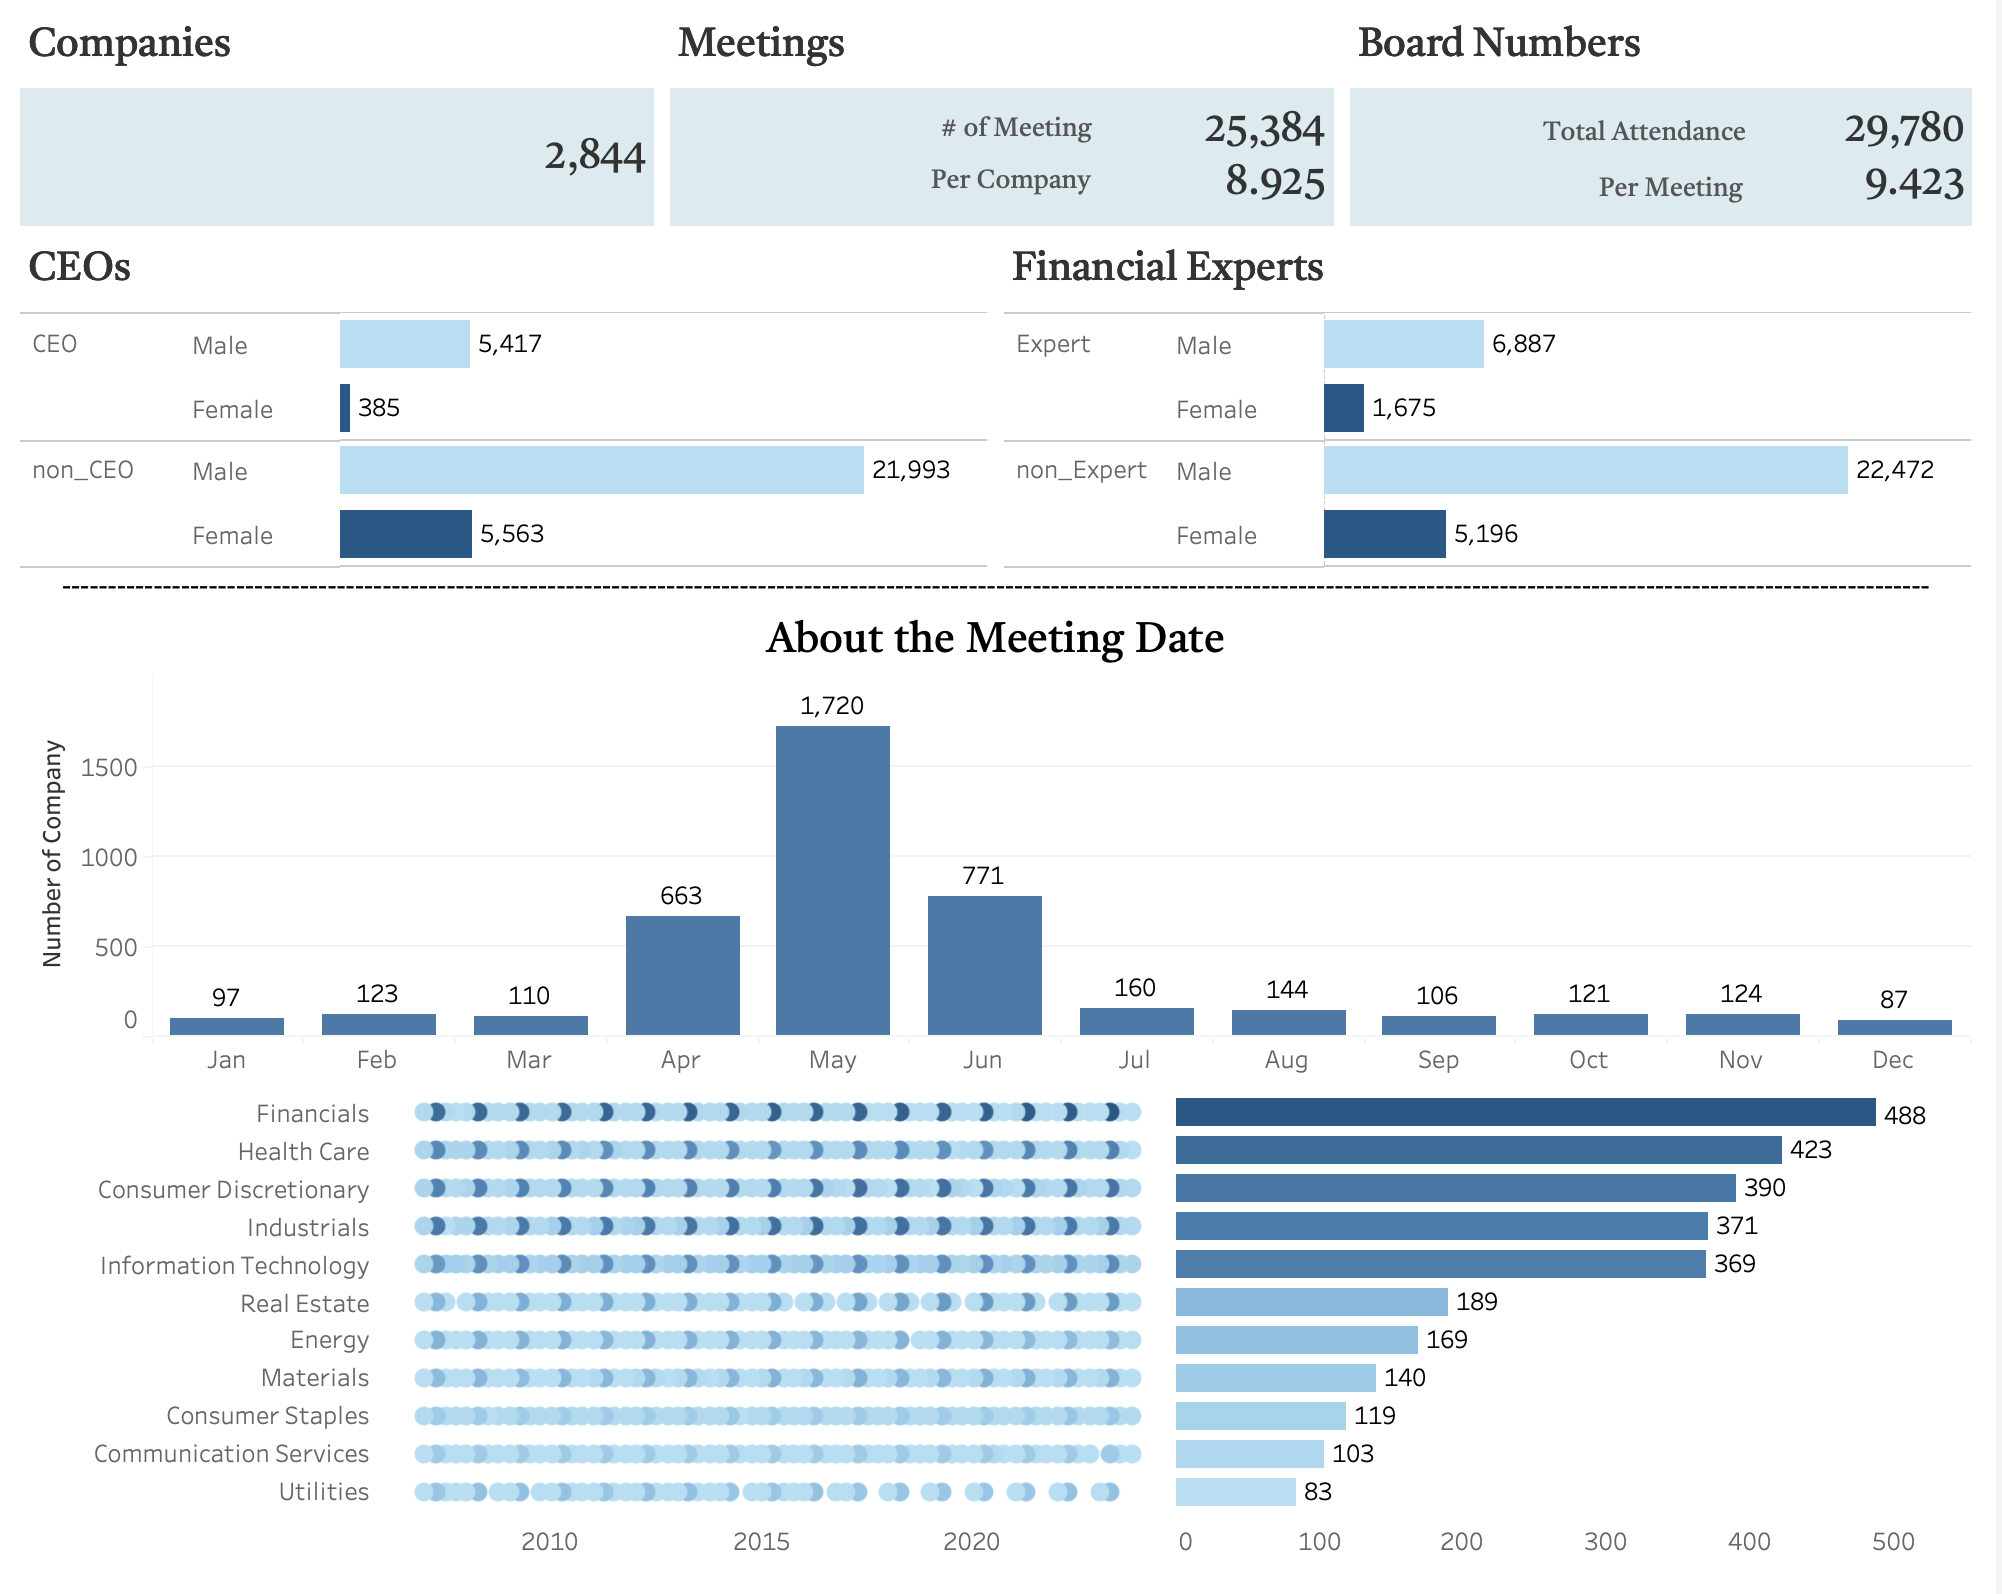

In the second dashboard, we present a detailed analysis of participant demographics, shedding light on various aspects of diversity and engagement within our organization. Through visually compelling representations, we showcase key metrics such as gender distribution, ethnicity, average age, average seniority, and average number of shares held by participants. Moreover, to facilitate deeper insights, we've incorporated a user-friendly filter allowing stakeholders to explore these metrics across different industry categories.

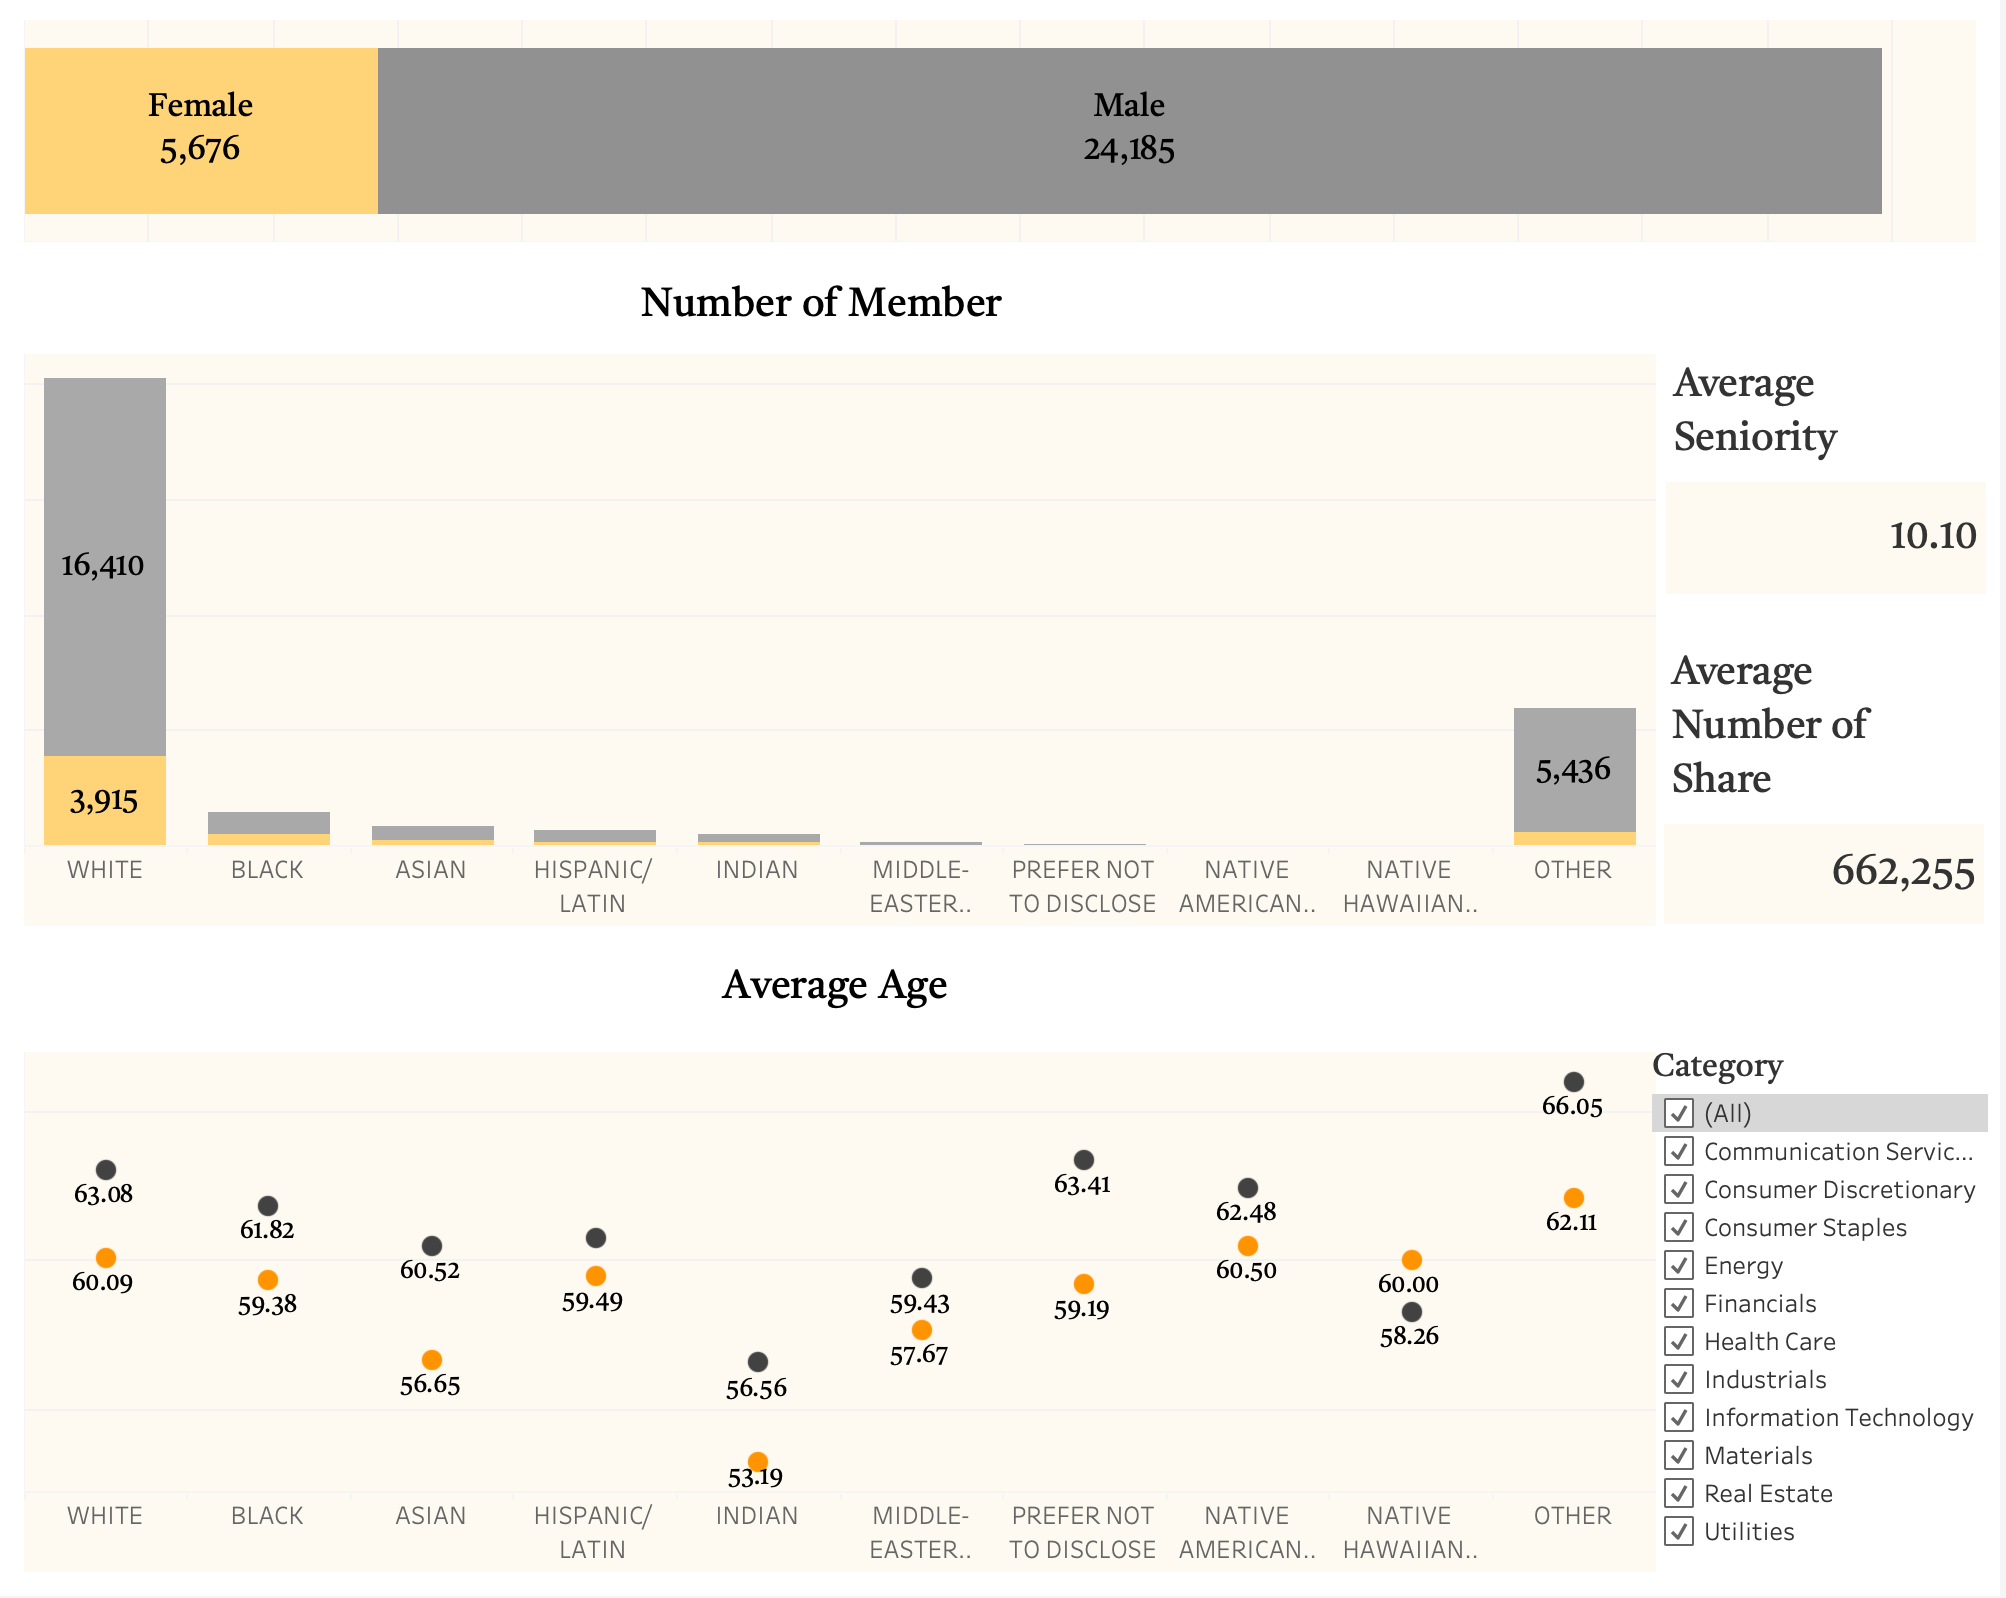

In our third Tableau dashboard, we conduct a comprehensive exploration of industry-specific performance, focusing on the fabrics, technology, and energy industries. In our analysis of the apparel industry, we observed a significant decline in return on assets (ROA) during the COVID-19 pandemic. The decline reflects the industry's struggles amid supply chain disruptions, reduced consumer spending and changing demand dynamics. Instead, our analysis of the energy sector reveals a remarkable post-pandemic recovery, characterized by a sharp rise in return on assets. Factors contributing to this recovery include increased energy demand, a recovery in oil prices and improved operating efficiencies driven by technological advancements. Additionally, in the Technology industry analysis, Nvidia (NVDA) stands out in particular, with a significant surge in ROA from 2016 to 2018. However, subsequent declines in ROA signal challenges or adjustments to NVDA's strategy or market dynamics, resulting in lower profitability.

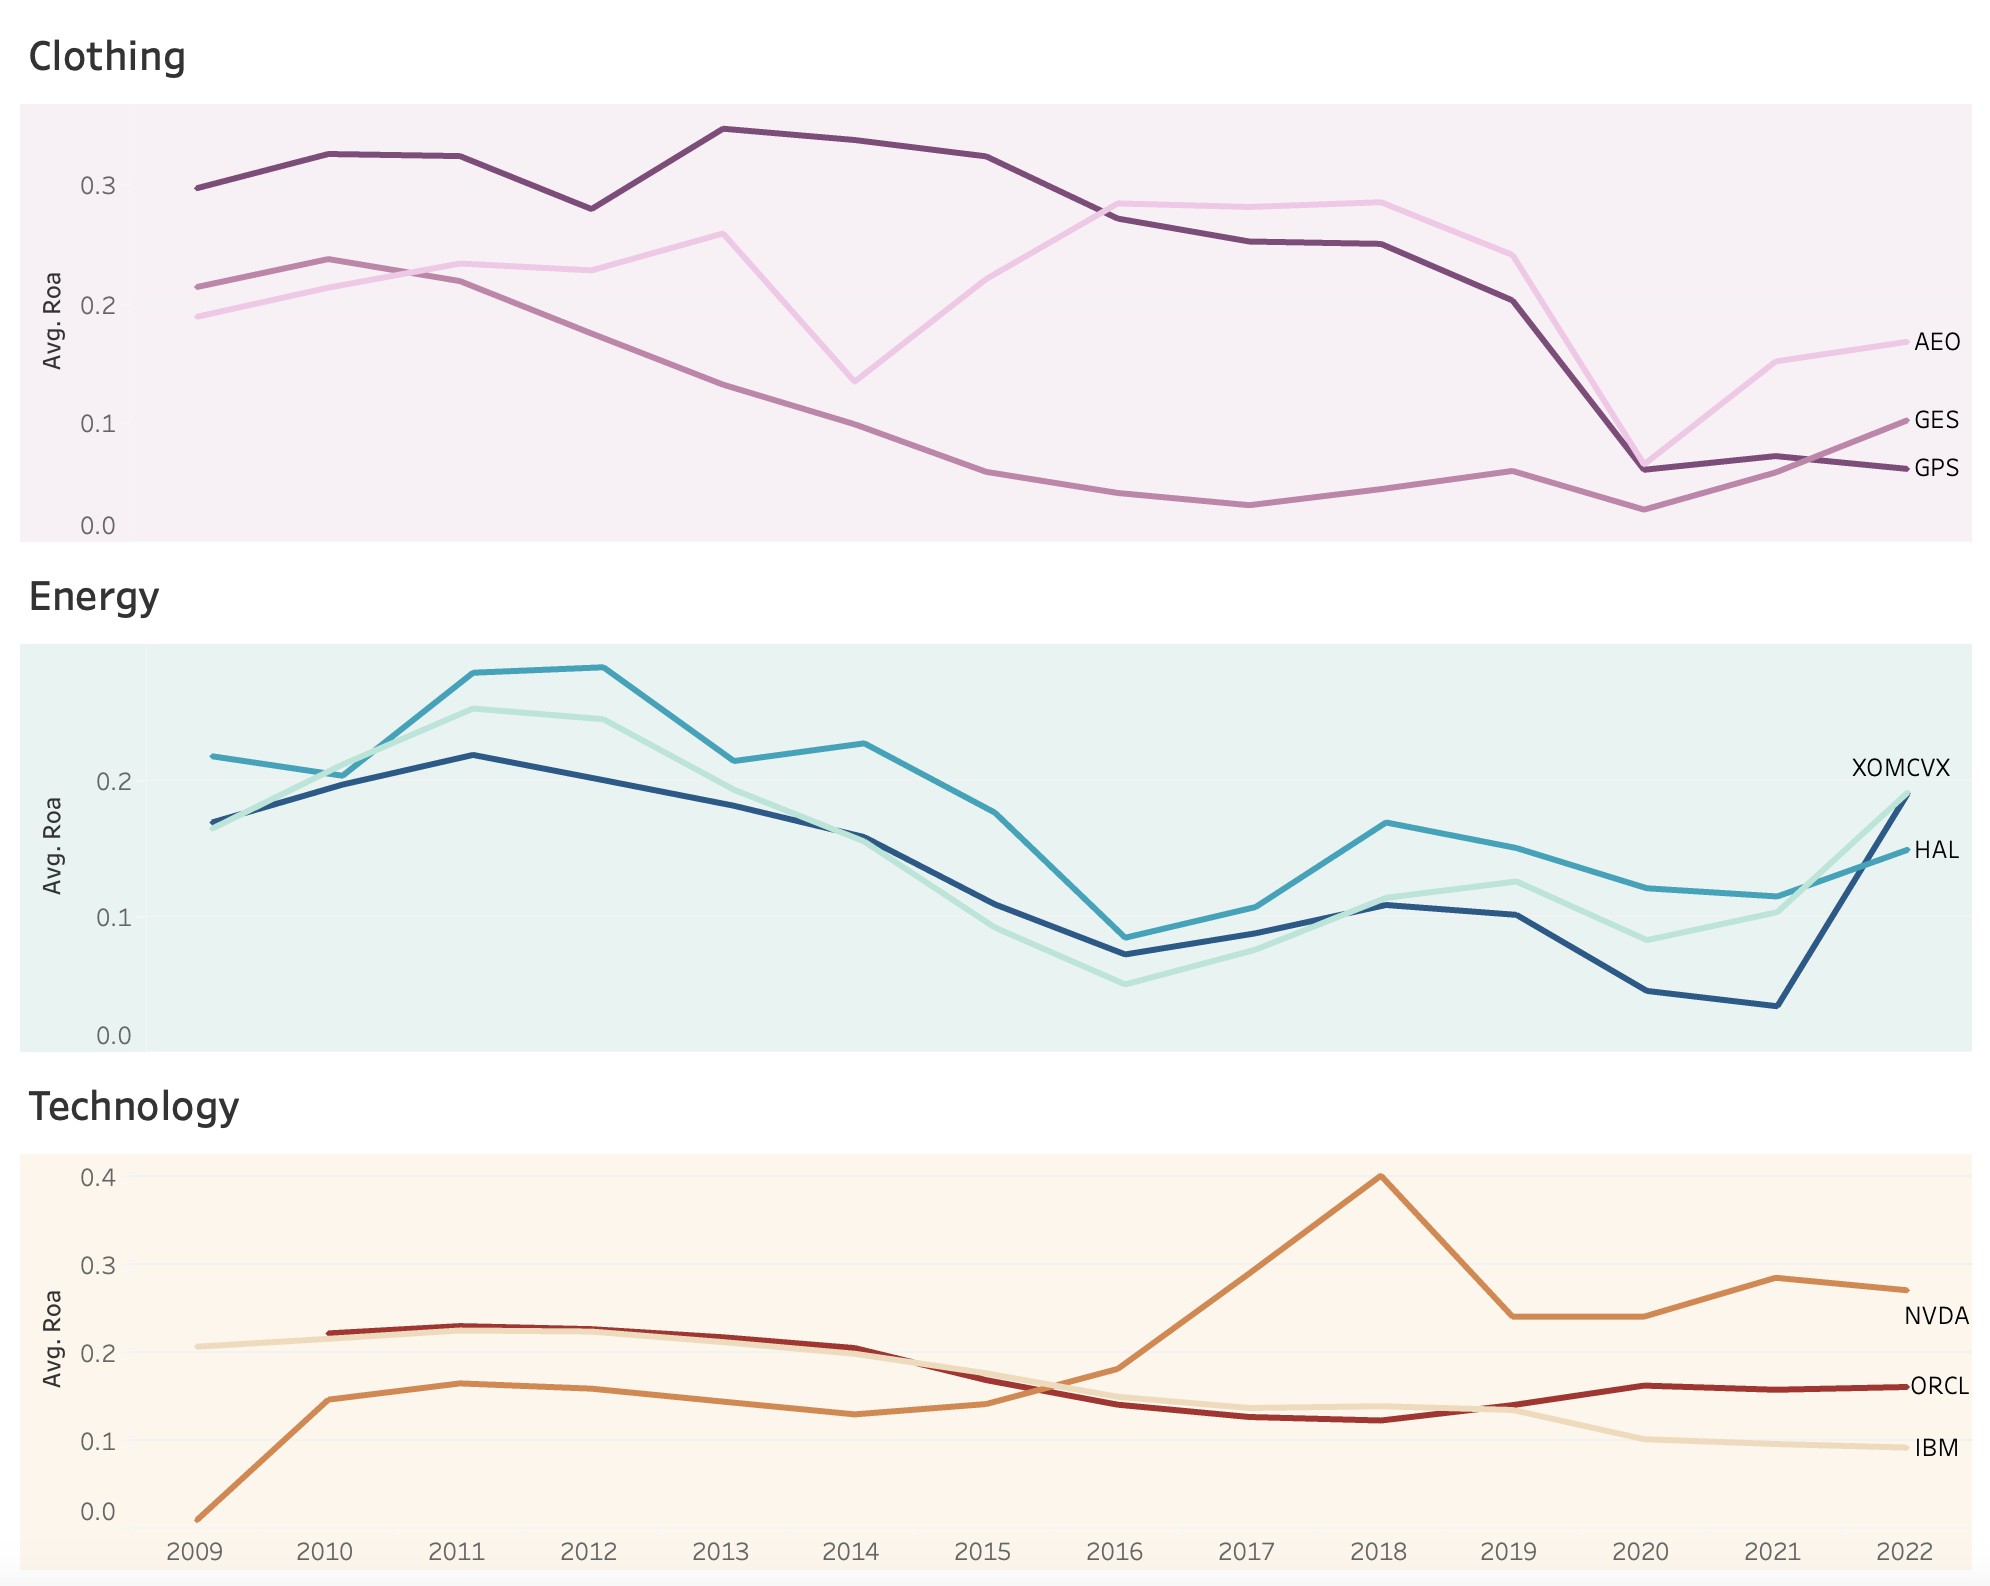

## **Conclusion**

**From the analysis of both the financial and ISS datasets, we have gained valuable insights into industry performance and the factors impacting Return on Assets (ROA). Notably, we have observed distinct trends across different industries. For instance, the clothing industry experienced a significant economic downturn characterized by supply chain disruptions and reduced consumer demand. Conversely, the energy sector showed signs of post-pandemic recovery, with increased demand, oil price stabilization, and enhanced operating efficiencies.**

**Furthermore, our analysis reveals that metrics such as female percentage, ethnicity, and CEO attendance have varying effects on ROA across industries. This suggests that factors related to diversity, leadership, and corporate governance play nuanced roles in influencing profitability metrics. These findings underscore the importance of considering industry-specific dynamics and company characteristics when assessing performance and identifying areas for improvement.**